# Planning a surf trip using IOOS EDS Model Viewer

Created: 2022-11-25

Updated: 2025-03-18

Author: [Mathew Biddle](mailto:mathew.biddle@noaa.gov)

**Resources:**
* EDS IOOS Model Viewer: https://eds.ioos.us/
* EDS IOOS Model Viewer Map: https://eds.ioos.us/map/
* EDS THREDDS Catalog: https://eds.ioos.us/thredds/catalog/catalog.html

Process:
1. Look at significant wave height forecast for MD coast (38.2101 °N 75.0867 °W). Look for significant wave heights >1m or some significant increase to narrow down the investigation. This will get you to a 12-24 hour window, typically.
   * Resources in EDS include:
     * GFS-Wave WW3 Atlantic Height @ NOAA GFS-Wave Atlantic Wave Height https://eds.ioos.us/thredds/catalog/ioos/gfswave/global/catalog.html
     * The Nearshore Wave Prediction System (NWPS) Chesapeake NWPS AKQ Wave Hgt @ NOAA NWPS Chesapeake Wave Height - https://eds.ioos.us/thredds/catalog/ioos/nwps/akq/catalog.html
     * Best GFS Wave Atlantic Ocean 16km Time Series - https://eds.ioos.us/thredds/dodsC/ioos/gfswave/atlocn/Best, https://eds.ioos.us/thredds/catalog/ioos/gfswave/atlocn/catalog.html?dataset=ioos/gfswave/atlocn/Best
     * For further South: SWAN model simulation for Puerto Rico and the US Virgin Islands - https://edsdata.oceansmap.com/thredds/catalog/EDS/CARIB_SWAN/catalog.html
1. Once you find a blip in wave heights, take a look at concurrent wave periods to see if it's just a storm or an offshore swell. Typically periods >5 seconds is a good start. That should get you down to a 12 hour window where it might be decent.
1. Next look at the forecasted wave direction and wind direction/speed. Lots of nuances in these two pieces as wind direction could be bad (onshore) but if speeds are low it could be alright. If wind direction good (offshore) but winds are strong, could be tricky. wave direction informs which spots would catch the swell. Not many features on MD coast (barrier island), so direction not as important. This should get you to a 6 hour'ish window.
1. Finally, look at tides and water temp (wetsuit or trunks?), sunrise, sunset times. Use https://erddap.sensors.ioos.us/erddap/index.html
1. Run this process every hour leading up to the event - forecast will get more accurate the closer to the event. I will start looking at real-time buoy obs ~12 hours before the event.

# Set up coordinates and time range for forecast

In [1]:
import datetime

lat = 38.2101
lon = -75.0867 

lon360 = 360+lon # convert to degrees_east 0-360

time_min = datetime.date.today()-datetime.timedelta(days=1)
time_max = datetime.date.today()+datetime.timedelta(days=7)

time = slice(time_min, time_max)

## Put coordinates on a map

Text(0.5, 1.0, 'lon:-75.0867 lat:38.2101')

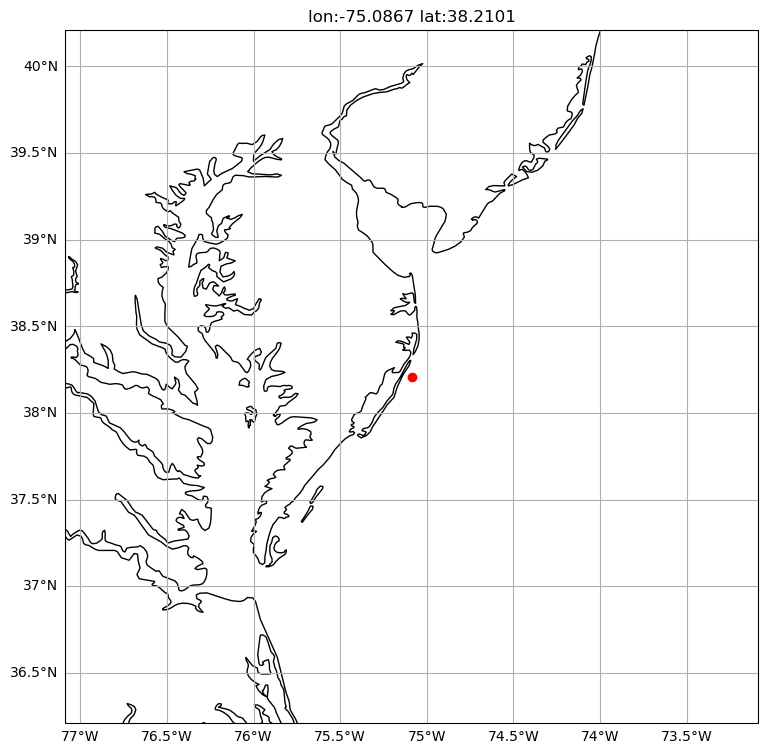

In [2]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import matplotlib.pyplot as plt

projection=ccrs.PlateCarree() 
figsize=(9, 9)

title=f'lon:{lon} lat:{lat}'

fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection=projection))
gl = ax.gridlines(draw_labels=True)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.plot(lon, lat, markersize=6, marker='o', color='red')

ax.set_extent([lon-2, lon+2, lat-2, lat+2], ccrs.PlateCarree())

ax.coastlines("10m")

plt.title(title)

# Query the various models for the appropriate data

In this cell we iterate through the various THREDDS endpoint to query for data matching the criteria specified above.

We use [`xarray`](https://docs.xarray.dev/en/stable/) to make our lives easier by searching for the specified location and time range.

Getting data from https://tds.ioos.us/thredds/dodsC/ioos/gfswave/atlocn/Best
Getting data from https://tds.ioos.us/thredds/dodsC/ioos/nwps/akq/Best/LatLon_229X153-37p66N-75p76W-3
Getting data from https://tds.ioos.us/thredds/dodsC/ioos/gfswave/global/Best
CPU times: total: 672 ms
Wall time: 1min 2s


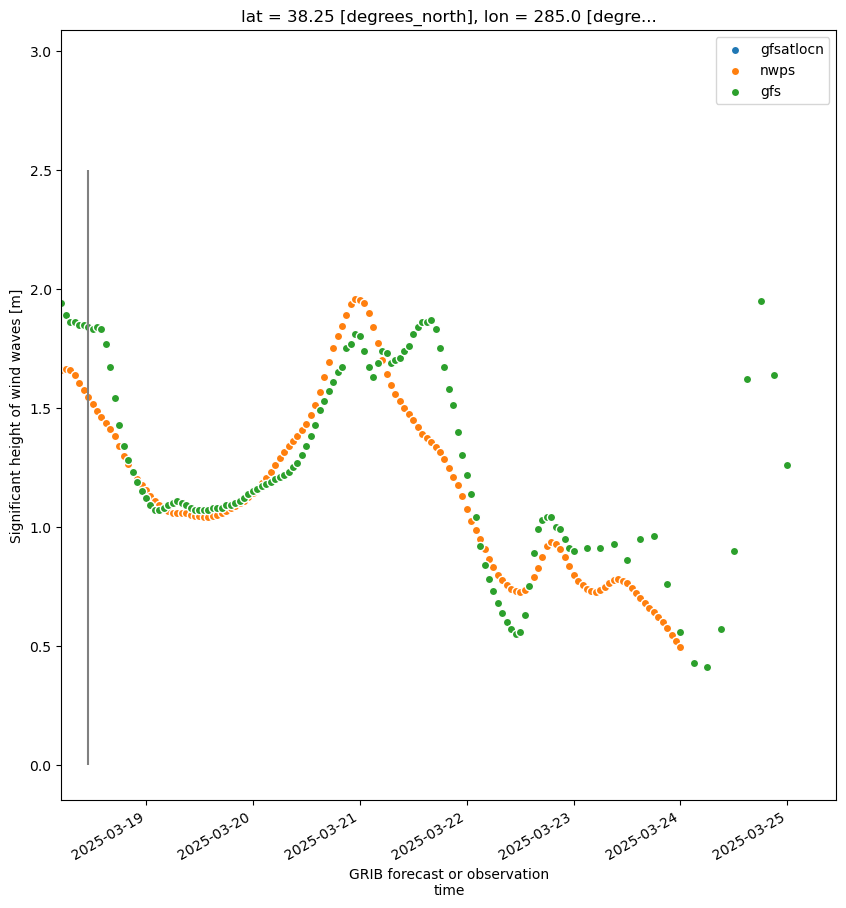

In [3]:
%%time

import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import datetime

# initialize figure
fig, ax = plt.subplots(figsize=(10, 10))

urls = {'gfsatlocn': 'https://tds.ioos.us/thredds/dodsC/ioos/gfswave/atlocn/Best',
       'nwps': 'https://tds.ioos.us/thredds/dodsC/ioos/nwps/akq/Best/LatLon_229X153-37p66N-75p76W-3',
       'gfs': 'https://tds.ioos.us/thredds/dodsC/ioos/gfswave/global/Best'
       }

# initialize output dataframe
df_out = pd.DataFrame({'time':[]})

for key in urls.keys():
    
    print('Getting data from {}'.format(urls[key]))
    
    ds = xr.open_dataset(urls[key])
    data = ds.filter_by_attrs(abbreviation='HTSGW').sel(lat=lat, lon=lon360, method="nearest").sel(time=time)

    df = data.to_dataframe().reset_index()

    suffix='_{}'.format(key)

    df_out = pd.merge_ordered(left=df, right=df_out, on='time', suffixes=[suffix,None])
    
    data.plot.scatter(x='time', y=list(data.data_vars)[0], ax=ax, label=key)
   
    
# add legend
ax.legend()

xmin = datetime.datetime.today()-datetime.timedelta(hours=6)
xmax = datetime.datetime.today()+datetime.timedelta(days=7)

# set limits
ax.set_xlim([xmin, xmax] )

ax.set_ylabel('Significant height of wind waves [m]')

# add a line for right now
ax.vlines(datetime.datetime.today(),ymin=0,ymax=2.5,color='grey')

## Next we are interested in looking at real-time data for a location near our point.

We can look at the [IOOS Sensor Map](https://sensors.ioos.us/) to find a station and then create a timeseries plot in the tool. 

Or, we can use the [IOOS Sensor Map ERDDAP](https://erddap.sensors.ioos.us/erddap/index.html) to search for stations in our area with appropriate data.

This searches through the ERDDAP for appropriate datasets and returns metadata about each one as a DataFrame.

In [4]:
from erddapy import ERDDAP
import pandas as pd

server = "https://erddap.sensors.ioos.us/erddap/"

e = ERDDAP(
    server=server,
    protocol="tabledap",
    response="csv",
)

kw = {
    "standard_name": "sea_surface_wave_significant_height",
    "min_lon": float(lon-1),
    "max_lon": float(lon+1),
    "min_lat": float(lat-1),
    "max_lat": float(lat+1),
    "min_time": "now-1day",
    "max_time": "now",
}


search_url = e.get_search_url(response="csv", **kw)

stations = pd.read_csv(search_url)

stations

c:\Users\Mathew.Biddle\programs\Miniforge\envs\IOOS\Lib\site-packages\trio\_core\_multierror.py:406: RuntimeWarning: IPython detected, but you already have a custom exception handler installed. I'll skip installing Trio's custom handler, but this means exception groups will not show full tracebacks.
  warnings.warn(


,griddap,Subset,tabledap,Make A Graph,wms,files,Title,Summary,FGDC,ISO 19115,Info,Background Info,RSS,Email,Institution,Dataset ID
0,NaN,NaN,https://erddap.sensors.ioos.us/erddap/tabledap...,https://erddap.sensors.ioos.us/erddap/tabledap...,NaN,NaN,"224 - Wallops Island, VA (44089)","Timeseries data from '224 - Wallops Island, VA...",https://erddap.sensors.ioos.us/erddap/metadata...,https://erddap.sensors.ioos.us/erddap/metadata...,https://erddap.sensors.ioos.us/erddap/info/edu...,https://sensors.ioos.us/#metadata/130264/station,http://erddap.sensors.ioos.us/erddap/rss/edu_u...,https://erddap.sensors.ioos.us/erddap/subscrip...,Coastal Data Information Program (CDIP),edu_ucsd_cdip_224
1,NaN,NaN,https://erddap.sensors.ioos.us/erddap/tabledap...,https://erddap.sensors.ioos.us/erddap/tabledap...,NaN,NaN,"263 - Bethany Beach, DE (44084)","Timeseries data from '263 - Bethany Beach, DE ...",https://erddap.sensors.ioos.us/erddap/metadata...,https://erddap.sensors.ioos.us/erddap/metadata...,https://erddap.sensors.ioos.us/erddap/info/edu...,https://sensors.ioos.us/#metadata/127432/station,http://erddap.sensors.ioos.us/erddap/rss/edu_u...,https://erddap.sensors.ioos.us/erddap/subscrip...,Coastal Data Information Program (CDIP),edu_ucsd_cdip_263
2,NaN,NaN,https://erddap.sensors.ioos.us/erddap/tabledap...,https://erddap.sensors.ioos.us/erddap/tabledap...,NaN,NaN,44009 (LLNR 168) - DELAWARE BAY 26 NM Southeas...,Timeseries data from '44009 (LLNR 168) - DELAW...,https://erddap.sensors.ioos.us/erddap/metadata...,https://erddap.sensors.ioos.us/erddap/metadata...,https://erddap.sensors.ioos.us/erddap/info/gov...,https://sensors.ioos.us/#metadata/130602/station,http://erddap.sensors.ioos.us/erddap/rss/gov-n...,https://erddap.sensors.ioos.us/erddap/subscrip...,NOAA National Data Buoy Center (NDBC),gov-ndbc-44009


## Let's get the real-time data

Now that we know what datasets match our criteria, we can go out and gather the actual values.

In [5]:
dataset_ids = stations['Dataset ID']

dfs= {}

def request_station(dataset_ids):
    for dataset_id in dataset_ids:
        e.dataset_id = dataset_id
        
        e.variables = ["time", 
                       "longitude", 
                       "latitude", 
                       "sea_surface_wave_significant_height", 
                       "sea_surface_wave_mean_period",
                      ]
        
        e.constraints = {
            "time>=": "now-2days",
            "time<": "now",
        }
        
        df = e.to_pandas().dropna()
    
        dfs[dataset_id] = df
    
    return (dfs)

dfs = request_station(dataset_ids)

## Make a map of the stations we found in our search.

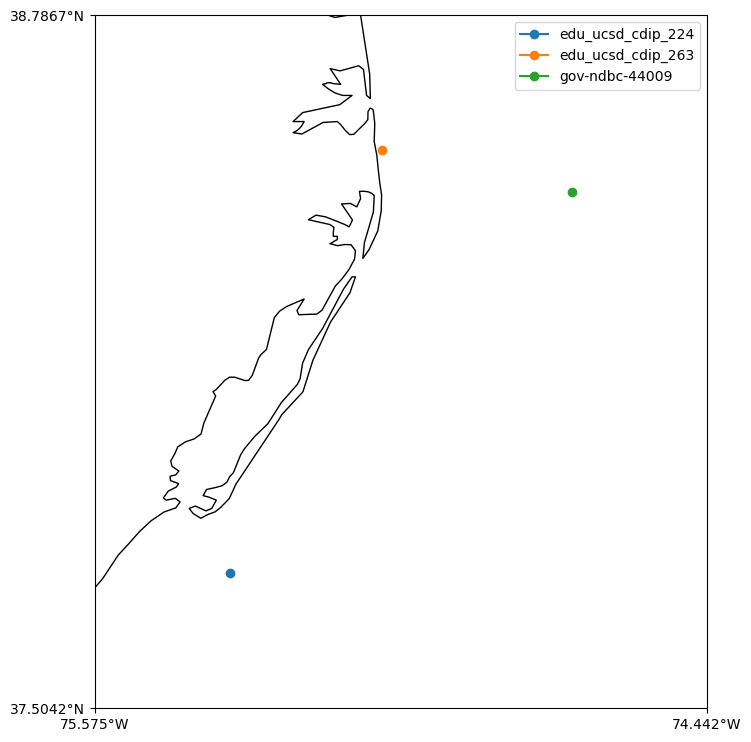

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


def make_map():
    fig, ax = plt.subplots(
        figsize=(9, 9),
        subplot_kw=dict(projection=ccrs.PlateCarree())
    )
    ax.coastlines(resolution="10m")
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    return fig, ax


fig, ax = make_map()
lons, lats = [], []
for station, df in dfs.items():
    lon, lat = df["longitude (degrees_east)"].unique(), df["latitude (degrees_north)"].unique()
    lons.extend(lon)
    lats.extend(lat)
    ax.plot(lon, lat, marker='o', label=station)

dx = dy = 0.25
extent = min(lons)-dx, max(lons)+dx, min(lats)-dy, max(lats)+dy
ax.set_extent(extent)

ax.set_xticks([extent[0], extent[1]], crs=ccrs.PlateCarree())
ax.set_yticks([extent[2], extent[3]], crs=ccrs.PlateCarree());
ax.legend()

Let's look at the last day of observations for those stations.

CPU times: total: 78.1 ms
Wall time: 95.8 ms


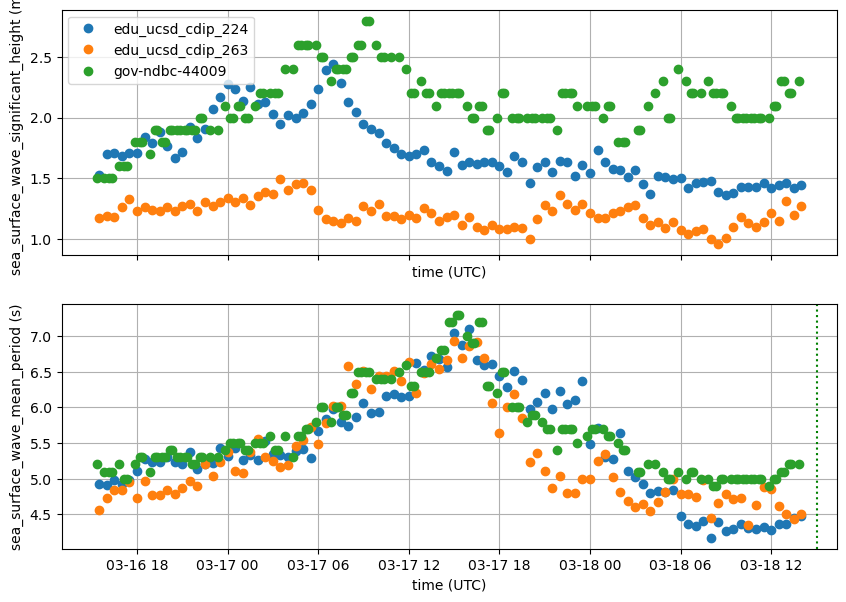

In [7]:
%%time
import matplotlib.dates as dates
import datetime
import pytz

def station_scatter(df, station, ax):
    ax[0].plot_date(dates.date2num(df["time (UTC)"]), df["sea_surface_wave_significant_height (m)"], 
                 xdate=True, 
                 tz='UTC', 
                 label=station)#, s=10, alpha=0.25)
    
    ax[1].plot_date(dates.date2num(df["time (UTC)"]), df["sea_surface_wave_mean_period (s)"], 
                 xdate=True, 
                 tz='UTC', 
                 label=station)#, s=10, alpha=0.25)


fig, ax = plt.subplots(ncols=1,nrows=2,figsize=(10, 7), sharex=True)
ax[0].set_ylabel("sea_surface_wave_significant_height (m)")
ax[0].set_xlabel("time (UTC)")
ax[0].grid(True)
ax[1].set_ylabel("sea_surface_wave_mean_period (s)")
ax[1].set_xlabel("time (UTC)")
ax[1].grid(True)


for station, df in dfs.items():
    station_scatter(df, station, ax)

#ax.axis([5.5, 30, 30, 38])
ax[0].legend()
plt.axvline(datetime.datetime.now(pytz.timezone('UTC')), color='green', linestyle=":")

# Overlay models with in-situ observations

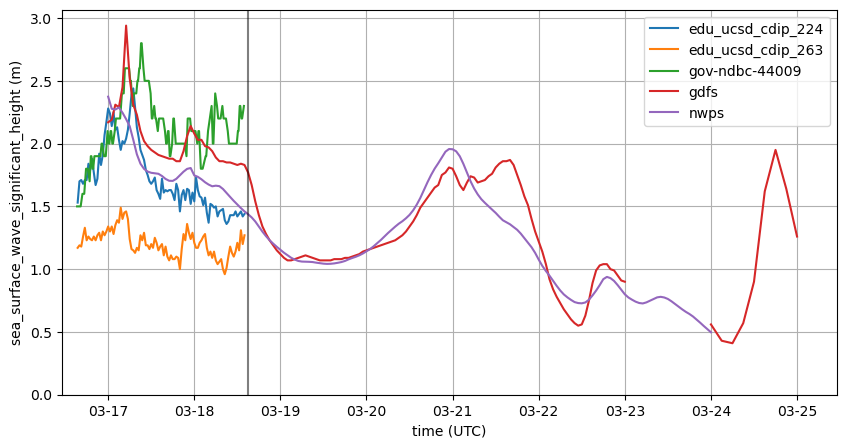

In [8]:
import matplotlib.dates as dates
import datetime
import pytz

dfs['gdfs'] = df_out[['time','Significant_height_of_combined_wind_waves_and_swell_surface_gfs']].copy()
dfs['nwps'] = df_out[['time','Significant_height_of_combined_wind_waves_and_swell_surface_nwps']].copy()

dfs['gdfs'].rename(columns={'Significant_height_of_combined_wind_waves_and_swell_surface_gfs':'sea_surface_wave_significant_height (m)',
                   'time': 'time (UTC)'}, inplace=True)
dfs['nwps'].rename(columns={'Significant_height_of_combined_wind_waves_and_swell_surface_nwps':'sea_surface_wave_significant_height (m)',
                   'time': 'time (UTC)'}, inplace=True)

dfs.keys()

def station_scatter(df, station, ax):
    ax.plot(dates.date2num(df["time (UTC)"]), df["sea_surface_wave_significant_height (m)"], 
                 #xdate=True, 
                 #tz='UTC', 
                 label=station,
                 linestyle='-',
                 markersize=2)#, s=10, alpha=0.25)


fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(10, 5))
ax.set_ylabel("sea_surface_wave_significant_height (m)")
ax.set_xlabel("time (UTC)")
ax.grid(True)


for station, df in dfs.items():
    station_scatter(df, station, ax)


ax.legend()
plt.axvline(datetime.datetime.now(pytz.timezone('UTC')), color='black', linestyle="-",alpha=0.5)

xmin = datetime.datetime.today()-datetime.timedelta(days=2)
xmax = datetime.datetime.today()+datetime.timedelta(days=7)

# set limits
ax.set_xlim( [xmin, xmax] )

ax.set_ylim(bottom=0)

ax.xaxis.set_major_formatter(
    dates.DateFormatter('%m-%d'))

## Combine the timeseries and map into one figure